In [5]:
import warnings
warnings.filterwarnings("ignore")
print('OK')
import sklearn.neighbors
from sklearn.mixture import BayesianGaussianMixture

from sklearn.metrics import silhouette_score, pair_confusion_matrix
from torch_geometric.data import Data

import scanpy as sc
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import scipy.sparse as sp
from SCGDL import ResGatedGraphmodel
from SCGDL_auxiliary import Adata2Torch_data
import torch
import torch.backends.cudnn as cudnn
cudnn.deterministic = True
cudnn.benchmark = True
from torch_geometric.nn import DeepGraphInfomax
from SCGDL_auxiliary import eval_model,get_adata,mk_dir
import psutil,time,tracemalloc

OK


In [6]:

def Adata2Torch_data(adata):
    G_df = adata.uns['Spatial_Net'].copy()
    spots = np.array(adata.obs_names)
    spots_id_tran = dict(zip(spots, range(spots.shape[0])))
    G_df['Spot1'] = G_df['Spot1'].map(spots_id_tran)
    G_df['Spot2'] = G_df['Spot2'].map(spots_id_tran)

    G = sp.coo_matrix((np.ones(G_df.shape[0]), (G_df['Spot1'], G_df['Spot2'])), shape=(adata.n_obs, adata.n_obs))
    G = G + sp.eye(G.shape[0])

    edgeList = np.nonzero(G)
    if type(adata.X) == np.ndarray:
        data = Data(edge_index=torch.LongTensor(np.array(
            [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X))
    else:
        data = Data(edge_index=torch.LongTensor(np.array(
            [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X.todense()))
    return data


def Spatial_Dis_Cal(adata, rad_dis=None, knn_dis=None, model='Radius', verbose=True):
    assert (model in ['Radius', 'KNN'])
    if verbose:
        print('------Calculating spatial graph...')
    coor = pd.DataFrame(adata.obsm['spatial'])
    coor.index = adata.obs.index
    coor.columns = ['Spatial_X', 'Spatial_Y']

    if model == 'Radius':
        nbrs = sklearn.neighbors.NearestNeighbors(radius=rad_dis).fit(coor)
        distances, indices = nbrs.radius_neighbors(coor, return_distance=True)
        KNN_list = []
        for spot in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([spot] * indices[spot].shape[0], indices[spot], distances[spot])))

    if model == 'KNN':
        nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=knn_dis + 1).fit(coor)
        distances, indices = nbrs.kneighbors(coor)
        KNN_list = []
        for spot in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([spot] * indices.shape[1], indices[spot, :], distances[spot, :])))

    KNN_df = pd.concat(KNN_list)
    KNN_df.columns = ['Spot1', 'Spot2', 'Distance']

    Spatial_Net = KNN_df.copy()
    Spatial_Net = Spatial_Net.loc[Spatial_Net['Distance'] > 0,]
    id_spot_trans = dict(zip(range(coor.shape[0]), np.array(coor.index), ))
    Spatial_Net['Spot1'] = Spatial_Net['Spot1'].map(id_spot_trans)
    Spatial_Net['Spot2'] = Spatial_Net['Spot2'].map(id_spot_trans)
    if verbose:
        print('The graph contains %d edges, %d spots.' % (Spatial_Net.shape[0], adata.n_obs))
        print('%.4f neighbors per spot on average.' % (Spatial_Net.shape[0] / adata.n_obs))

    adata.uns['Spatial_Net'] = Spatial_Net


In [7]:
def Spatial_Dis_Draw(adata):
    import matplotlib.pyplot as plt
    Num_edge = adata.uns['Spatial_Net']['Spot1'].shape[0]
    Mean_edge = Num_edge / adata.shape[0] #
    plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Spot1']))
    plot_df = plot_df / adata.shape[0]
    fig, ax = plt.subplots(figsize=[4, 4], dpi=300)
    plt.ylabel('Percentage')
    plt.xlabel('Edge Numbers per Spot')
    plt.title('Number of Neighbors for Spots (Average=%.2f)' % Mean_edge)
    ax.bar(plot_df.index, plot_df, color="#aa40fc", edgecolor="#f7b6d2", linewidth=2)



def DGI_loss_Draw(adata):
    import matplotlib.pyplot as plt
    if "SCGDL_loss" not in adata.uns.keys():
        raise ValueError("Please Train DGI Model using SCGDL_Train function first!")
    Train_loss = adata.uns["SCGDL_loss"]
    plt.style.use('default')
    plt.plot(Train_loss, label='Training loss', linewidth=2)
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss of DGI model")
    plt.legend()
    plt.grid()
    plt.show()

## without_label
def BGMM_no_label(adata, used_obsm='SCGDL'):

    knowledge = BayesianGaussianMixture(
                                        weight_concentration_prior_type='dirichlet_process',
                                        ##'dirichlet_process' or dirichlet_distribution'
                                        weight_concentration_prior=50).fit(adata.obsm[used_obsm])

    labels = knowledge.predict(adata.obsm[used_obsm]) + 1 #自动识别聚类数
    adata.obs["BGMM_auto_cluster"] =labels
    adata.obs["BGMM_auto_cluster"] = adata.obs["BGMM_auto_cluster"].astype('category')
    print("adata.obs[BGMM].value_count",adata.obs["BGMM_auto_cluster"].value_counts())
    # adata.write('SCGDL_BGMM_cluster_emb_151676.h5ad')
    return adata


def BGMM(adata, n_cluster, used_obsm='SCGDL'):

    knowledge = BayesianGaussianMixture(n_components=n_cluster,
                                        weight_concentration_prior_type='dirichlet_process',
                                        ##'dirichlet_process' or dirichlet_distribution'
                                        weight_concentration_prior=50).fit(adata.obsm[used_obsm])

    labels = knowledge.predict(adata.obsm[used_obsm]) + 1 #[1,7]
    adata.obs["BayesianGaussianMixture"] =  labels
    adata.obs["BayesianGaussianMixture"] = adata.obs["BayesianGaussianMixture"].astype('category')
    return adata

def SCGDL_Train(adata,
                hidden_dims=[128, 128],
                num_epochs=1000,
                lr=1e-6,
                key_added='SCGDL',
                gradient_clipping=5.,
                weight_decay=0.0001,
                random_seed=0, save_loss=True):
    seed = random_seed
    import random
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

    adata.X = sp.csr_matrix(adata.X)

    if "Spatial_highly_variable_genes" in adata.var.columns:
        adata_Vars = adata[:, adata.var['Spatial_highly_variable_genes']]
        print('Input Size using Spatial_variable_genes: ', adata_Vars.shape)
    elif 'highly_variable' in adata.var.columns:
        adata_Vars = adata[:, adata.var['highly_variable']]
        print('Input Size using Highly_variable_genes: ', adata_Vars.shape)
    else:
        adata_Vars = adata
        print('Input Size using All genes list: ', adata_Vars.shape)

    if 'Spatial_Net' not in adata.uns.keys():
        raise ValueError("Please Compute Spatial Network using Spatial_Dis_Cal function first!")

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    data = Adata2Torch_data(adata_Vars)
    hidden_dims = [data.x.shape[1]] + hidden_dims

    DGI_model = DeepGraphInfomax(
        hidden_channels=hidden_dims[1],
        encoder=ResGatedGraphmodel(hidden_dims),
        summary=lambda z, *args, **kwargs: torch.sigmoid(z.mean(dim=0)),
        corruption=corruption).to(device)
    DGI_optimizer = torch.optim.Adam(DGI_model.parameters(), lr=lr, weight_decay=weight_decay)
    data = data.to(device)

    import time
    start_time = time.time()
    loss_list = []
    for epoch in tqdm(range(1, num_epochs + 1)):
        DGI_model.train()
        DGI_optimizer.zero_grad()
        pos_z, neg_z, summary = DGI_model(data=data)
        DGI_loss = DGI_model.loss(pos_z, neg_z, summary)
        loss_list.append(DGI_loss.item())
        DGI_loss.backward()
        torch.nn.utils.clip_grad_norm_(DGI_model.parameters(), gradient_clipping)
        DGI_optimizer.step()
        if ((epoch) % 1000) == 0:
            print('Epoch: {:03d}, Loss: {:.4f}'.format(epoch, np.mean(loss_list)))
    end_time = time.time()
    print('Elapsed training time:{:.4f} seconds'.format((end_time - start_time)))

    DGI_model.eval()
    pos_z, neg_z, summary = DGI_model(data=data)

    SCGDL_rep = pos_z.to('cpu').detach().numpy()
    adata.obsm[key_added] = SCGDL_rep #把得到的emb数组，保存在obsm中

    if save_loss:
        adata.uns['SCGDL_loss'] = loss_list

    return adata


class my_data():
    def __init__(self, x, edge_index, edge_attr):
        self.x = x
        self.edge_index = edge_index
        self.edge_attr = edge_attr


def corruption(data):
    x = data.x[torch.randperm(data.x.size(0))]
    return my_data(x, data.edge_index, data.edge_attr)


====================begin test on 151673======================================
load DLPFC dataset:
------Calculating spatial graph...
The graph contains 21124 edges, 3639 spots.
5.8049 neighbors per spot on average.
Input Size using All genes list:  (3639, 33538)


100%|██████████| 1000/1000 [01:17<00:00, 12.83it/s]


Epoch: 1000, Loss: 1.3034
Elapsed training time:77.9738 seconds


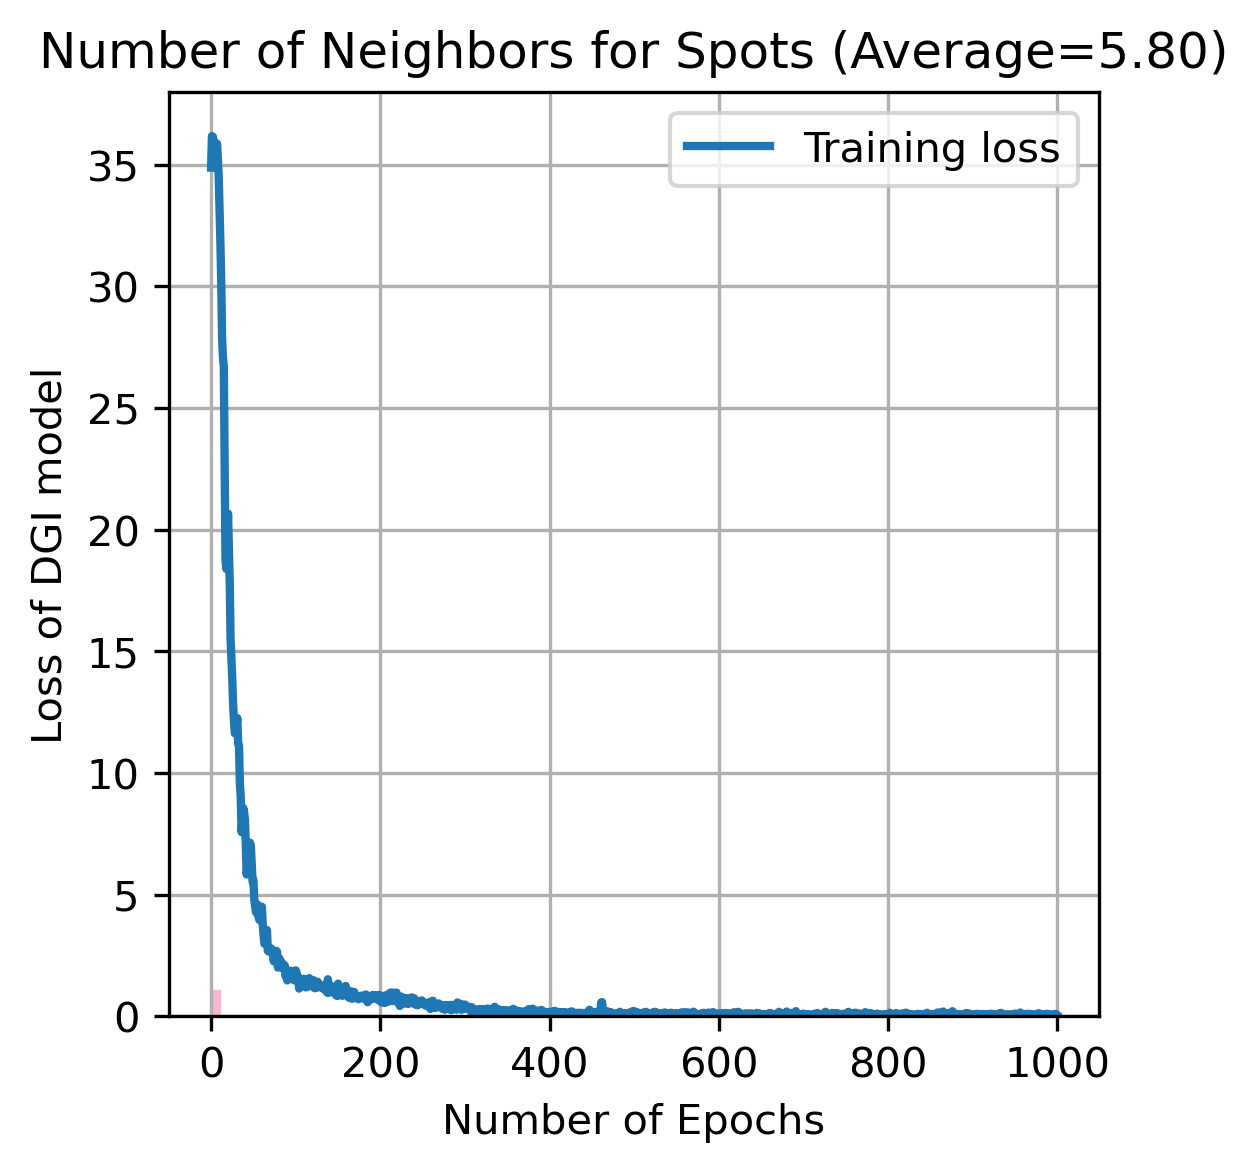

Current memory usage_end:：-1.4279 GB
time: 90.0623 s
memory blocks peak:    0.4572 GB
  dataset       ari       nmi       ami        sc  SC_revise      time  \
0  151673  0.314159  0.416574  0.414978  0.191303    0.07826  90.06232   

       Memo  Memo_peak  round  
0 -1.427895   0.457227      1  
              ari       nmi       ami        sc  SC_revise      time  \
dataset                                                                
151673   0.314159  0.416574  0.414978  0.191303    0.07826  90.06232   

             Memo  Memo_peak  round  
dataset                              
151673  -1.427895   0.457227      1  


In [8]:
import sys
sys.path.append('../')
import utils_for_all as usa
if __name__ == '__main__':
    Dataset=["Mouse_brain","Breast_cancer","PDAC","Stereo","STARmap"]
    dataset2 = ['151507', '151508', '151509', '151510','151669', '151670', '151671', '151672', '151673', '151674', '151675', '151676']
    dataset3=['151673']
for dataset in dataset3:
    print(f"====================begin test on {dataset}======================================")

    if dataset.startswith('15'):
        save_data_path=f'../../Output/SCGDL/DLPFC/{dataset}/'
    else:
        save_data_path = f'../../Output/SCGDL/{dataset}/'
    mk_dir(save_data_path)

    adata, n_cluster = usa.get_adata(dataset, data_path='../../Dataset/')
    adata.var_names_make_unique()

    results = pd.DataFrame()
    for i in range(1):
        random_seed = 0
        start = time.time()
        tracemalloc.start()
        start_MB = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024
        rad_dis = 150
        Spatial_Dis_Cal(adata,rad_dis= rad_dis) #calculate distance
        Spatial_Dis_Draw(adata) #count average edge
        adata = SCGDL_Train(adata,hidden_dims=[128, 128],num_epochs=1000)
        DGI_loss_Draw(adata) # draw SCGDL_loss
        sc.pp.neighbors(adata, use_rep='SCGDL')
        sc.tl.umap(adata)


        # adata = BGMM_no_label(adata,used_obsm='SCGDL')
        adata = BGMM(adata,n_cluster,used_obsm='SCGDL')
        adata.write(f'{save_data_path}SCGDL_{dataset}.h5ad')

        ari,nmi,ami=eval_model( adata.obs["BayesianGaussianMixture"],adata.obs['ground_truth'])
        SC = silhouette_score(adata.obsm['SCGDL'],  adata.obs["BayesianGaussianMixture"])

        used_adata = adata[adata.obs["ground_truth"].notna()]
        SC_revise = silhouette_score(used_adata.obsm['SCGDL'], used_adata.obs['ground_truth'])

        end = time.time()
        end_MB = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024
        uesd_time = end - start
        used_memo = end_MB - start_MB
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        peak = peak / 1024.0 / 1024.0 / 1024.0
        print(u'Current memory usage_end:：%.4f GB' % used_memo)
        print('time: {:.4f} s'.format(uesd_time))
        print('memory blocks peak:{:>10.4f} GB'.format(peak))
        tracemalloc.clear_traces()

        res = {}
        res["dataset"] =dataset
        res["ari"] = ari
        res["nmi"] = nmi
        res["ami"] = ami
        res["sc"] = SC
        res['SC_revise'] = SC_revise
        res["time"] = uesd_time
        res["Memo"] = used_memo
        res["Memo_peak"] = peak
        res["round"] = i + 1

        results = results._append(res, ignore_index=True)
        print(results.head())
        results.to_csv(f'{save_data_path}{dataset}_result.csv')

    results.set_index('dataset', inplace=True)
    print(results.head())
    res_mean = results.mean()
    res_mean.to_csv(f'{save_data_path}{dataset}_mean.csv', header=True)
    res_std = results.std()
    res_std.to_csv(f'{save_data_path}{dataset}_std.csv', header=True)
    res_median = results.median()
    res_median.to_csv(f'{save_data_path}{dataset}_median.csv', header=True)  #
